In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from SALib.sample import sobol_sequence
from scipy.stats import norm, uniform
import sys

In [2]:
print('Python version: {}'.format(sys.version))
print('Numpy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))

Python version: 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
Numpy version: 1.15.4
Pandas version: 0.23.4


## Definition of y and z, subsets of x:

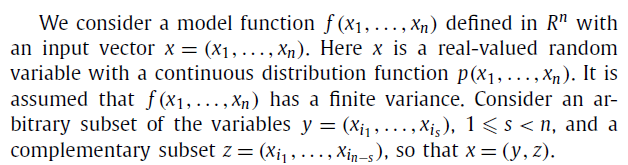

In [3]:
Image(filename='img/model_variables.PNG')

## Sampling from a conditional normal distribution, the procedure is implemented below:

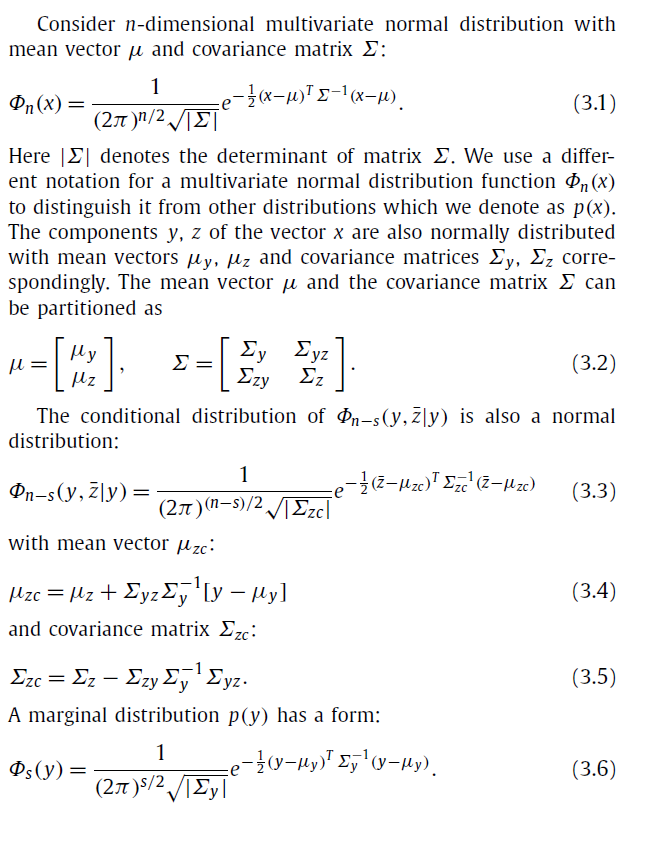

In [4]:
Image(filename='img/generate_dependent_variables.PNG')

In [5]:
def conditional_sampling(u2, x1, mu_x1, mu_x2, cov, s, lower_cond=True):
    '''
    Find vector x2 conditioned on vector x1
     
    --------
    u2: 
        independent random vector in [0,1] used to create the conditional variables
         
    x1: 
        independent variables
         
    mu_x1, mu_x2, cov: 
        mean of independent variables; mean of conditional variables; covariance matrix
         
    s:
        splitting position between independent and conditional varaibles
         
    lower_cond: 
         if the the conditional variables are those after position s. Default is True.
    '''
                  
    # if x2 is the lower vector:
    if lower_cond:
        x1i, x1f = 0, s
        x2i, x2f = s, None
        
    else:
        x1i, x1f = s, None
        x2i, x2f = 0, s

    covx1 = cov[x1i:x1f, x1i:x1f]
    covx2x1 = cov[x2i:x2f, x1i:x1f]
     
    # conditional mu and covariance:           
    mu_x2_c = mu_x2 + covx2x1.dot(np.linalg.inv(covx1)).dot(x1.T-mu_x1)
    cov_x2_c = np.linalg.inv(np.linalg.inv(cov)[x2i:x2f, x2i:x2f])

    L_x2_c = np.linalg.cholesky(cov_x2_c)
    x2_c = mu_x2_c + np.dot(L_x2_c, norm.ppf(u2).T)
     
    return x2_c.T

## The algorithm proposed in the paper (implementation below):

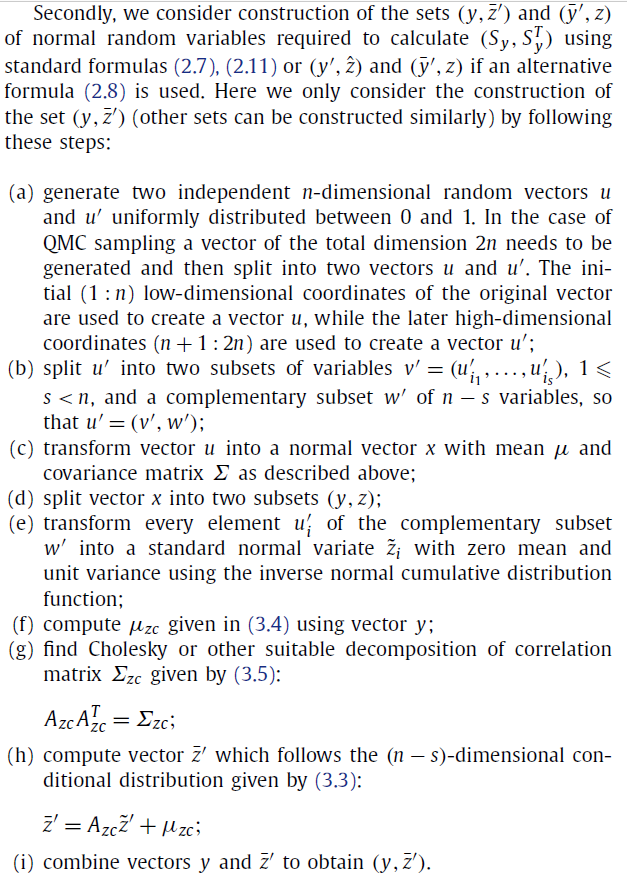

In [6]:
Image(filename='img/alghoritm.PNG')

In [7]:
def kucherenko_sampling(problem, N, cov, mu, s=1):
    '''
    Implementation of the alghoritm proposed in:
     
    S. Kucherenko, S. Tarantola, P. Annoni. Estimation of global sensitivity indices for models with dependent variables
    Comput. Phys. Commun., 183 (4) (2012), pp. 937-946
     
    to generate two sets of independent and conditional variables.
     
    --------
    problem: dict
         
    N: int
         independent variables
         
    mu, cov: 
         mean of variables; covariance matrix
         
    s: int
        splitting position between independent and conditional varaibles
    '''    
    
    factors_order = cov.columns.values
    D = problem['num_vars']
    
    # How many values of the Sobol sequence to skip
    skip_values = 1000

    base_sequence = sobol_sequence.sample(N+skip_values, 2 * D)
    u = base_sequence[skip_values:, :D]
    u_ = base_sequence[skip_values:, D:]
    
    zu = norm.ppf(u)
    L = np.linalg.cholesky(cov)
    x = mu + np.dot(L, zu.T)
    
    v_ = u_[:, :s]
    w_ = u_[:, s:]
    y = x.T[:, :s]
    z = x.T[:, s:]
        
    cov_new = np.cov(x)
    
    mu_y = np.mean(y, axis = 0).reshape(y.shape[1], 1)
    mu_z = np.mean(z, axis = 0).reshape(z.shape[1], 1)

    zc_n = conditional_sampling(w_, y, mu_y, mu_z, cov_new, s, True)
    yc_n = conditional_sampling(v_, z, mu_z, mu_y, cov_new, s, False)
        
    x_df = pd.DataFrame(np.hstack([y, z]), columns = factors_order)
    xc_df = pd.DataFrame(np.hstack([yc_n, zc_n]), columns = factors_order)
                
    return x_df, xc_df

### Computation of the Sobol indexes as expressed in formulas 5.3 and 5.4:

In [8]:
def sobol_indexes(fun, x, xc, problem, s=1):
    '''
    Compute Sobol Indexes
     
    --------
    fun: function
     
    x: array_like
        The independent vector
        
    xc: array_like
         The conditional vector
         
    problem: dict
         
    s: int
        splitting position between independent and conditional variables
    '''        
        
    fnc = x.columns[:s]
    fc = x.columns[s:]
        
    x = x[np.sort(x.columns)]
    xc = xc[np.sort(x.columns)]
    
    # get the marginals' distributions
    for dist in np.unique(problem['dist']):
        logical = problem['dist'] == dist
        
        cols = x.columns[logical]
        prms = problem['prms'][logical]
                
        x[cols] = to_marginal(x[cols], dist, prms)
        xc[cols] = to_marginal(xc[cols], dist, prms)
        
    y_zc = pd.concat([x[fnc], xc[fc]], axis=1)[np.sort(x.columns)]
    yc_z = pd.concat([xc[fnc], x[fc]], axis=1)[np.sort(x.columns)]

    f_y_z = fun(x.values)

    f_y_zc = fun(y_zc.values)
    f_yc_z = fun(yc_z.values)
    
    mean_sq_yz = np.mean(f_y_z**2)
    sq_mean_yz = np.mean(f_y_z)**2
    Vy = mean_sq_yz - sq_mean_yz
    
    # Equation 5.3
    Sy = (np.mean(f_y_z*f_y_zc) - sq_mean_yz)/Vy
    
    # Equation 5.4
    STy = np.mean((f_y_z - f_yc_z)**2)/(2*Vy)

    return Sy, STy

Utils functions: 
- get the marginal distributions (only a few are implemented);
- transform the covariance matrix and the vector of mean values in order to get the variables of interest as the y sub-vector of x (to recall: x = [y,z])

In [9]:
def to_marginal(x, dist, prms):
    dist = eval(dist)
    
    if dist == norm:
        pass
    
    elif dist == uniform:
        loc = prms[:,0]
        scale = prms[:,1] - loc
                
        x = pd.DataFrame(dist.ppf(norm.cdf(x), loc = loc,scale = scale), 
                        columns=x.columns)

    elif dist == gumbel_r:
        loc = prms[:,0]
        scale = prms[:,1]
        
        x = pd.DataFrame(dist.ppf(norm.cdf(x), loc = loc,scale = scale), 
                        columns=x.columns)

    elif dist == exponweib:
        loc = prms[:,0]
        scale = prms[:,1]
        shp1 = prms[:,2]
        shp2 = prms[:,3]
        
        x = pd.DataFrame(dist.ppf(norm.cdf(x), shp1, shp2, loc = loc,scale = scale), 
                        columns=x.columns)        
        
    elif dist == lognorm:
        loc = prms[:,0]
        scale = prms[:,1]
        shp1 = prms[:,2]
        
        x = pd.DataFrame(dist.ppf(norm.cdf(x), shp1, loc = loc,scale = scale), 
                        columns=x.columns)
    else:
        raise('Unknown distribution')
    
    return x

def build_cov_mu(cov, mu, factors):
    '''
    Return ordered covariance matrix
    
    ------
    cov: DataFrame
         covariance matrix in the original order
         
    mu: array_like
         vector of mean values in the original order         
         
    factors: list
         list of input variables of interest   
    '''
    
    new_factors_order = factors + [f for f in cov.columns if not f in factors]
    ordered_cov = cov.loc[new_factors_order, new_factors_order]
    ordered_mu = mu[new_factors_order]
    
    return ordered_cov, ordered_mu

# EXAMPLES:

In [10]:
def test_fun1(args):
    return np.sum(args, axis=1)

def test_fun2(args):
    x1,x2,x3,x4 = np.hsplit(args,4)
    return x1*x3+x2*x4

def test_fun3(args):
    x1, x2, x3 = np.hsplit(args,3)
    y = np.sin(x1)+7.*np.sin(x2)**2+0.1*x3**4*np.sin(x1)
    return y

### About the *'problem'* dictionary: inspired by the SALib library. Here it can have keys:
- num_vars: number of variables; *int*
- dist: vector of input variables' distribution in the orginal order; *array_like*
- prms: vector of distributions' parameters in the order: loc, scale, shape parameters; *array_like*

## First Example

In [11]:
rho_s = [0., 0.5, -0.5, 0.8, -0.8]
     
mu = np.array([[0.0], [0.0], [0.0]])
problem = {'num_vars': 3, 'dist': np.array(3*['norm']), 'prms': np.array([[0., 1.], 
                                                                          [0., 1.], 
                                                                          [0., 4.]])}
N = 1500

for rho in rho_s:
    results = pd.DataFrame(columns = ['S', 'ST'], 
                           index = ['X{}'.format(i) for i in range(1,problem['num_vars']+1)])

    df_cov = pd.DataFrame([[1.,0.,0.],
                           [0.,1.,rho*2.],
                           [0.,rho*2.,4.]])

    print('rho = {}'.format(rho))
    
    # X1
    factors = [0]
    
    cov_, mu_ = build_cov_mu(df_cov, mu, factors)
    
    x, xc = kucherenko_sampling(problem, N, cov_, mu_)
    a, b = sobol_indexes(test_fun1, x, xc, problem=problem)
    
    results.loc['X1','S'] = a; results.loc['X1','ST'] = b
    
    # X2
    factors = [1]
    
    cov_, mu_ = build_cov_mu(df_cov, mu, factors)
    
    x, xc = kucherenko_sampling(problem, N, cov_, mu_)
    a, b = sobol_indexes(test_fun1, x, xc, problem=problem)
    
    results.loc['X2','S'] = a; results.loc['X2','ST'] = b
    
    # X3
    factors = [2]

    cov_, mu_ = build_cov_mu(df_cov, mu, factors)
    
    x, xc = kucherenko_sampling(problem, N, cov_, mu_)
    a, b = sobol_indexes(test_fun1, x, xc, problem=problem)
    
    results.loc['X3','S'] = a; results.loc['X3','ST'] = b
    
    print(results)
    print('\n')

rho = 0.0
           S        ST
X1  0.160204  0.166698
X2  0.160204  0.166698
X3  0.666616  0.664613


rho = 0.5
           S         ST
X1  0.119189   0.124935
X2  0.498518  0.0937188
X3  0.781664   0.374027


rho = -0.5
            S        ST
X1   0.246611  0.250143
X2 -0.0112764  0.187286
X3   0.561858  0.746157


rho = 0.8
           S         ST
X1   0.10512   0.108544
X2  0.735123  0.0390325
X3  0.852551   0.155925


rho = -0.8
           S        ST
X1  0.357782  0.357523
X2   0.11747  0.128345
X3  0.513729  0.510899




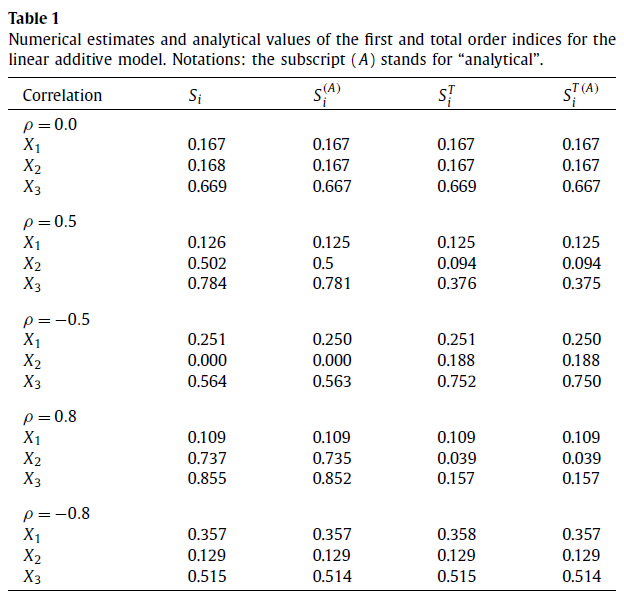

In [12]:
Image(filename='img/example1.PNG')

### Try to estimate the sensitivity index for a group of dependent variables:
- Include the factors of interest in the *factors* list;
- Specify the splitting position *s*;

In [13]:
# X1,X2
factors = [0, 1]
    
cov_, mu_ = build_cov_mu(df_cov, mu, factors)
    
x, xc = kucherenko_sampling(problem, N, cov_, mu_, s=len(factors))
a, b = sobol_indexes(test_fun1, x, xc, problem=problem, s=len(factors))

print('rho = {}'.format(rho))
print('First order index of variables (x1,x2): {}'.format(a))
print('Total order index of variables (x1,x2): {}'.format(b))

rho = -0.8
First order index of variables (x1,x2): 0.4858849428098923
Total order index of variables (x1,x2): 0.4863625086238755


## Second Example

In [14]:
N = 15000
mu = np.array([[0.0], [0.0], [250.0], [400.0]])

df_cov = pd.DataFrame([[16.0, 2.4, 0., 0.],
                    [2.4, 4., 0., 0.],
                    [0., 0., 4.0*1e4, -1.8*1e4],
                    [0., 0., -1.8*1e4, 9*1e4]])

problem = {'num_vars': 4, 'dist': np.array(4*['norm']), 'prms': np.array([[0., 16.], 
                                                                          [0., 4.], 
                                                                          [250., 4.0*1e4],
                                                                          [400., 9*1e4]])}
results = pd.DataFrame(columns = ['S', 'ST'], 
                       index = ['X{}'.format(i) for i in range(1,problem['num_vars']+1)])

In [15]:
# X1
factors = [0]

cov_, mu_ = build_cov_mu(df_cov, mu, factors)

x, xc = kucherenko_sampling(problem, N, cov_, mu_)
a, b = sobol_indexes(test_fun2, x, xc, problem)

results.loc['X1','S'] = a; results.loc['X1','ST'] = b

In [16]:
# X2
factors = [1]
cov_, mu_ = build_cov_mu(df_cov, mu, factors)

x, xc = kucherenko_sampling(problem, N, cov_, mu_)
a, b = sobol_indexes(test_fun2, x, xc, problem)

results.loc['X2','S'] = a; results.loc['X2','ST'] = b

In [17]:
# X3
factors = [2]
cov_, mu_ = build_cov_mu(df_cov, mu, factors)

x, xc = kucherenko_sampling(problem, N, cov_, mu_)
a, b = sobol_indexes(test_fun2, x, xc, problem)

results.loc['X3','S'] = a; results.loc['X3','ST'] = b

In [18]:
# X4
factors = [3]
cov_, mu_ = build_cov_mu(df_cov, mu, factors)

x, xc = kucherenko_sampling(problem, N, cov_, mu_)
a, b = sobol_indexes(test_fun2, x, xc, problem)

results.loc['X4','S'] = a; results.loc['X4','ST'] = b

print(results)

              S        ST
X1     0.504686  0.491747
X2     0.397266  0.299716
X3  0.000222857  0.191204
X4  0.000271654  0.107435


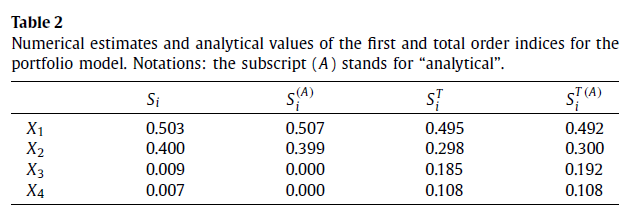

In [19]:
Image(filename='img/example2.PNG')

### Sensitivity index for a group of dependent variables:

In [20]:
# X1,X2
factors = [0, 1, 3]
    
cov_, mu_ = build_cov_mu(df_cov, mu, factors)
    
x, xc = kucherenko_sampling(problem, N, cov_, mu_, s=len(factors))
a, b = sobol_indexes(test_fun2, x, xc, problem=problem, s=len(factors))

print('First order index of variables (x1,x2): {}'.format(a))
print('Total order index of variables (x1,x2): {}'.format(b))

First order index of variables (x1,x2): 0.8067883196441524
Total order index of variables (x1,x2): 1.0004142527799231


## Third example

In [21]:
N = 8000
mu = np.array([[0.], [0.], [0.]])
problem = {'num_vars': 3,
           'prms': np.array([[-np.pi, np.pi], 
                             [-np.pi, np.pi], 
                             [-np.pi, np.pi]]),
            'dist': np.array(3*['uniform'])}

S_dict = {'Sx1':[], 'STx1':[], 'Sx2':[], 'STx2':[], 'Sx3':[], 'STx3':[]}
rho_13_s = np.arange(-0.9, 0.91, 0.2)

for rho_13 in rho_13_s:
    
    df_cov = pd.DataFrame([[1., 0., rho_13],
                        [0., 1., 0.],
                        [rho_13, 0., 1.]])
    factors = [0]
    
    cov_, mu_ = build_cov_mu(df_cov, mu, factors)
    
    x, xc = kucherenko_sampling(problem, N, cov_, mu_)
    a, b = sobol_indexes(test_fun3, x, xc, problem=problem)
    S_dict['Sx1'].append(a); S_dict['STx1'].append(b)

    factors = [1]
    
    cov_, mu_ = build_cov_mu(df_cov, mu, factors)
    
    x, xc = kucherenko_sampling(problem, N, cov_, mu_)
    a, b = sobol_indexes(test_fun3, x, xc, problem=problem)
    S_dict['Sx2'].append(a); S_dict['STx2'].append(b)

    factors = [2]
    
    cov_, mu_ = build_cov_mu(df_cov, mu, factors)
    
    x, xc = kucherenko_sampling(problem, N, cov_, mu_)  
    a, b = sobol_indexes(test_fun3, x, xc, problem=problem)
    S_dict['Sx3'].append(a); S_dict['STx3'].append(b)

Text(0, 0.5, 'Sensitivity Index')

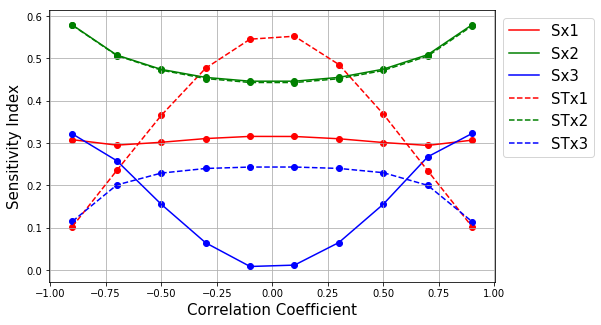

In [22]:
colors = dict(zip(range(3),['red','green','blue']))
i = 0
plt.figure(figsize=(8,5))
for key in ['Sx1', 'Sx2', 'Sx3']:
    plt.plot(rho_13_s, S_dict[key], label = key, color = colors[i])
    plt.scatter(rho_13_s, S_dict[key], color = colors[i])
    i += 1
    
i = 0
for key in ['STx1', 'STx2', 'STx3']:
    plt.plot(rho_13_s, np.array(S_dict[key]), '--', label = key, color = colors[i])
    plt.scatter(rho_13_s, np.array(S_dict[key]), color = colors[i])
    i += 1

plt.grid(True)
plt.legend(bbox_to_anchor = (1,1), fontsize = 15)
plt.xlabel('Correlation Coefficient', fontsize = 15)
plt.ylabel('Sensitivity Index', fontsize = 15)

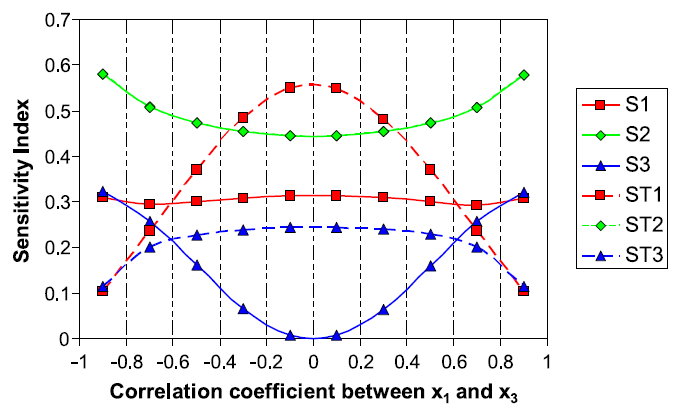

In [23]:
Image(filename='img/example3.PNG')